# Project 7 - SVM & Bayes

Ον/μο: Μαρία Καρλάκη ΑΕΜ:244

Ερώτημα 1 - Εισαγωγή βιβλιοθηκών

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import emoji
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

In [12]:
!pip install neattext
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.5 MB/s eta 0:00:00


Φόρτωση του dataset

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Διαχωρισμός dataset σε train/test με stratify

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'],
    test_size=0.1,
    stratify=df['target'],
    random_state=0
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 6851
Test size: 762


Bar plots με το πλήθος των target

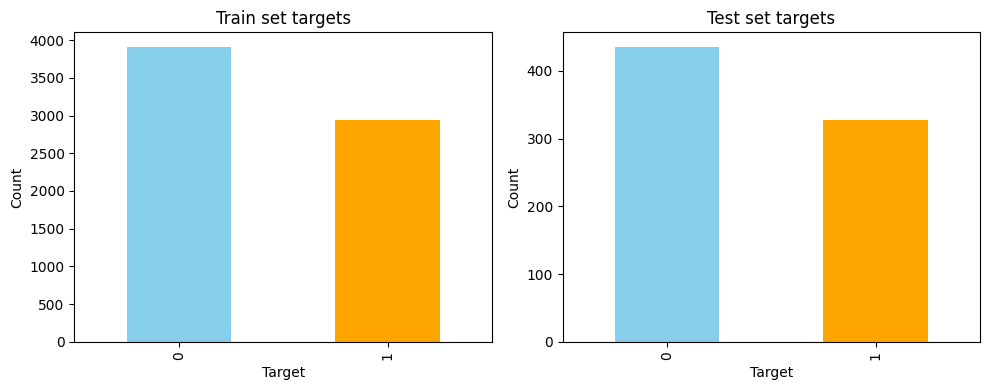

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'orange'])
axes[0].set_title('Train set targets')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Count')

y_test.value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'orange'])
axes[1].set_title('Test set targets')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Έλεγχος ισορροπίας dataset

In [5]:
print("Ποσοστά στο train set:")
print(y_train.value_counts(normalize=True))

print("\nΠοσοστά στο test set:")
print(y_test.value_counts(normalize=True))

Ποσοστά στο train set:
target
0    0.570282
1    0.429718
Name: proportion, dtype: float64

Ποσοστά στο test set:
target
0    0.570866
1    0.429134
Name: proportion, dtype: float64


Παρατηρούμε ότι το πλήθος των παραδειγμάτων με target=0 (μη καταστροφικά tweets, 57% σε train και test set) είναι ελαφρώς μεγαλύτερο από εκείνα με target=1 (tweets που αφορούν φυσικές καταστροφές, 43% σε train και test set). Το dataset μπορεί να θεωρηθεί σχετικά ισορροπημένο, οπότε δεν απαιτείται άμεσα εφαρμογή τεχνικών αντιμετώπισης ανισορροπίας (όπως oversampling ή class weighting).

Ερώτημα 2

Αφαίρεση των id και location

In [6]:
df = df.drop(columns=['id', 'location'])

Συμπλήρωση των ελλιπών τιμών με null

In [8]:
df = df.fillna('null')

Δημιουργία νέας στήλης inputs

In [9]:
df['inputs'] = df['keyword'] + ' ' + df['text']

In [10]:
df[['keyword', 'text', 'inputs']].head()

,keyword,text,inputs
0,null,Our Deeds are the Reason of this #earthquake M...,null Our Deeds are the Reason of this #earthqu...
1,null,Forest fire near La Ronge Sask. Canada,null Forest fire near La Ronge Sask. Canada
2,null,All residents asked to 'shelter in place' are ...,null All residents asked to 'shelter in place'...
3,null,"13,000 people receive #wildfires evacuation or...","null 13,000 people receive #wildfires evacuati..."
4,null,Just got sent this photo from Ruby #Alaska as ...,null Just got sent this photo from Ruby #Alask...


Ενημέρωση των train/test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['inputs'], df['target'],
    test_size=0.1,
    stratify=df['target'],
    random_state=0
)

Ερώτημα 3

Καθαρισμός των text

In [16]:
URL_RE = re.compile(r'http[s]?://\S+')
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
ELONGATED_RE = re.compile(r'(.)\1{2,}', re.UNICODE)
NON_ALNUM_SPACE_RE = re.compile(r'[^0-9a-zA-Z\s]+')

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = ''
    s = s.lower()
    s = URL_RE.sub(' ', s)
    s = MENTION_RE.sub(' ', s)
    s = HASHTAG_RE.sub(r'\1', s)
    s = emoji.replace_emoji(s, replace=' ')
    s = ELONGATED_RE.sub(r'\1\1', s)
    s = NON_ALNUM_SPACE_RE.sub(' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

train_df = pd.DataFrame({'clean_text': X_train_clean, 'target': y_train})
test_df  = pd.DataFrame({'clean_text': X_test_clean, 'target': y_test})

print(train_df.head(5).to_string(index=False))

print(test_df.head(5).to_string(index=False))

                                                                                                                                            clean_text  target
                                                                                  threat meek mill responds to drake s ovo fest set with wedgie threat       1
      flood survived the plague floated the flood just peeked our heads above the mud no one s immune deafening bells my god will we survive ourselves       0
                                    weapons kick hendrixonfire blackcats big noob conquest mixed maps all weapons for violated k dr limit server max 3       0
                                   deluge vince mcmahon once again a billionaire i remember reading a deluge of posts about vince mcmahon losing 350 m       0
hazardous is it possible to sneak into a hospital so i can stab myself with a hazardous needle and inject some crazy disease into my veins until i die       0
                                              

Για τον καθαρισμό των κειμένων επέλεξα να χρησιμοποιήσω τις εξής συναρτήσεις: την Lower (γιατί μετατρέπει όλα τα γράμματα σε πεζά μειώνοντας τον θόρυβο), την συνάρτηση για την αφαίρεση των συνδέσμων (καθώς δεν προσδιορίζουν κάποιο σημασιολογικό περιεχόμενο για την καταστροφή ή μη), την συνάρτηση που κάνει αναφορά σε άλλους χρήστες (@mention, γιατί δεν βοηθούν σε προβλέψεις και προσθέτουν θόρυβο), την συνάρτηση που χερίζεται τα hastags (συγκεκριμένα αφαιρεί το σύμβολο '#' και κρατά μόνο την υπόλοιπη λέξη που ουσιαστικά αυτή είναι η χρήσιμη ένδειξη), την συνάρτηση για αφαίρεση των emoji και άλλων ειδικών χαρακτήρων (γιατί η ύπαρξη τους είναι επιπλέον θόρυβος στα δεδομένα), την συνάρτηση για συμπίεση των τραβηγμένων γραμμάτων (πχ η λέξη fiiire σε fiire, για να ενοποίησουμε ισοδύναμα tokens) και την συνάρτηση για αφαίρεση σημείων στίξεων και καθαρισμό πολλών κενών (για να αποφύγουμε θόρυβο στα δεδομένα απο πληροφορία που δεν μας δίνει κάτι στην πρόβλεψη).

Ερώτημα 4

Χωρισμός των δεδομένων σε numpy arrays

In [19]:
X_train_np = np.array(X_train_clean)
X_test_np  = np.array(X_test_clean)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)

print("X_train_np:", X_train_np.shape)
print("X_test_np:", X_test_np.shape)
print("y_train_np:", y_train_np.shape)
print("y_test_np:", y_test_np.shape)

X_train_np: (6851,)
X_test_np: (762,)
y_train_np: (6851,)
y_test_np: (762,)


Ερώτημα 5

TF-IDF μετατροπή

In [22]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train_np)
X_test_tfidf = tfidf.transform(X_test_np)

print("TF-IDF train set:", X_train_tfidf.shape)
print("TF-IDF test set:", X_test_tfidf.shape)

TF-IDF train set: (6851, 5000)
TF-IDF test set: (762, 5000)


Ερώτημα 6

Εκπαίδευση του SVM ταξινομητή με linear Kernel

In [24]:
svm_model = LinearSVC(random_state=0)
svm_model.fit(X_train_tfidf, y_train_np)

y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test  = svm_model.predict(X_test_tfidf)

metrics = {
    "Accuracy": [
        accuracy_score(y_train_np, y_pred_train),
        accuracy_score(y_test_np,  y_pred_test)
    ],
    "Precision": [
        precision_score(y_train_np, y_pred_train),
        precision_score(y_test_np,  y_pred_test)
    ],
    "Recall": [
        recall_score(y_train_np, y_pred_train),
        recall_score(y_test_np,  y_pred_test)
    ],
    "F1-score": [
        f1_score(y_train_np, y_pred_train),
        f1_score(y_test_np,  y_pred_test)
    ]
}

results_df = pd.DataFrame(metrics, index=["Train", "Test"])
print(results_df)
print("\nDetailed classification report (Test set):")
print(classification_report(y_test_np, y_pred_test))

       Accuracy  Precision    Recall  F1-score
Train  0.917384   0.937776  0.865149  0.900000
Test   0.801837   0.787582  0.737003  0.761453

Detailed classification report (Test set):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       435
           1       0.79      0.74      0.76       327

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.80       762
weighted avg       0.80      0.80      0.80       762



Ο ταξινομητής SVM με γραμμικό πυρήνα πέτυχε 91.7% ακρίβεια στο σύνολο εκπαίδευσης και 80.2% στο σύνολο δοκιμής, γεγονός που υποδηλώνει καλή γενίκευση. Η ανάλυση των μετρικών δείχνει ικανοποιητική ικανότητα εντοπισμού καταστροφικών αναρτήσεων (Recall 0.74) και περιορισμό των ψευδών ειδοποιήσεων (Precision 0.79). Η F1-score (0.76) εκφράζει καλύτερα τη συνολική απόδοση, καθώς συνδυάζει ισορροπημένα τις δύο προηγούμενες μετρικές και είναι η πιο κατάλληλη για εφαρμογές όπου η σωστή αναγνώριση πραγματικών περιστατικών είναι κρίσιμη για την έγκαιρη προειδοποίηση. Οπότε στο συγκεκριμένο πρόβλημα η F1-score είναι η πιο σημαντική, καθώς πρόκειται για μεταβλητή που ισορροπεί (μέσος όρος) την recall και precision.

Ερώτημα 7

In [28]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

pca = PCA(n_components=0.95, random_state=0)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca  = pca.transform(X_test_dense)

print("Αριθμός συνιστωσών μετά το PCA:", X_train_pca.shape[1])

svm_linear_pca = LinearSVC(random_state=0)
svm_linear_pca.fit(X_train_pca, y_train_np)
y_pred_linear = svm_linear_pca.predict(X_test_pca)

svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf.fit(X_train_pca, y_train_np)
y_pred_rbf = svm_rbf.predict(X_test_pca)

def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

results = pd.DataFrame({
    "LinearSVC (PCA)": evaluate_model(y_test_np, y_pred_linear),
    "SVM RBF (PCA)": evaluate_model(y_test_np, y_pred_rbf)
}).T

print(results)

Αριθμός συνιστωσών μετά το PCA: 2116
                 Accuracy  Precision    Recall  F1-score
LinearSVC (PCA)  0.799213   0.788079  0.727829  0.756757
SVM RBF (PCA)    0.821522   0.832753  0.730887  0.778502


Ο μετασχηματισμός PCA με διατήρηση του 95% της πληροφορίας μείωσε σημαντικά τη διάσταση των δεδομένων (σε 2.116 συνιστώσες), χωρίς αξιοσημείωτη απώλεια ακρίβειας. Μετά το PCA, ο ταξινομητής SVM με RBF kernel παρουσίασε ελαφρώς καλύτερη συνολική απόδοση (Accuracy=0.82, F1=0.78) σε σχέση με τον LinearSVC (Accuracy=0.80, F1=0.76). Αυτό δείχνει ότι η χρήση μη γραμμικού πυρήνα επιτρέπει στο μοντέλο να ανιχνεύει πιο περίπλοκα πρότυπα στο κείμενο, ενώ ο γραμμικός ταξινομητής παραμένει μια αποδοτική και πρακτική λύση με μικρότερο υπολογιστικό κόστος.

Ερώτημα 8

Η παράμετρος γ στον ταξινομητή SVM καθορίζει την ακτίνα επιρροής ενός μεμονωμένου δείγματος εκπαίδευσης πάνω στο όριο απόφασης. Μικρές τιμές της γ (πχ 0.1) σημαίνουν μεγάλη εμβέλεια, όπου κάθε σημείο επηρεάζει ένα ευρύτερο τμήμα του χώρου των χαρακτηριστικών. Το αποτέλεσμα μπορεί να οδηγήσει σε υποπροσαρμογή, καθώς το μοντέλο αδυνατεί να αποτυπώσει την πολυπλοκότητα των δεδομένων. Αντίθετα, μεγάλες τιμές της γ (πχ 100) συνεπάγονται μικρή, τοπική εμβέλεια, όπου κάθε σημείο επηρεάζει μόνο τη γειτονιά του. Το όριο απόφασης γίνεται πολύ περίπλοκο, προσπαθώντας να περιβάλλει ακόμα και μεμονωμένα δείγματα, γεγονός που οδηγεί σε υπερπροσαρμογή και χαμηλή γενίκευση.

In [30]:
n_features = X_train_pca.shape[1]
var_X = np.var(X_train_pca)

gamma_auto = 1 / n_features
gamma_scale = 1 / (n_features * var_X)

print("n_features:", n_features)
print("Variance of X_train_pca:", var_X)
print("gamma (auto):", gamma_auto)
print("gamma (scale):", gamma_scale)

n_features: 2116
Variance of X_train_pca: 0.00044696891677454284
gamma (auto): 0.0004725897920604915
gamma (scale): 1.0573213803564605


                       Accuracy  F1-score  Precision  Recall
LinearSVC (PCA)           0.799     0.757      0.788   0.728
SVM RBF (scale)           0.822     0.779      0.833   0.731
SVM RBF (auto)            0.571     0.000      0.000   0.000
LinearSVC (χωρίς PCA)     0.802     0.761      0.788   0.737


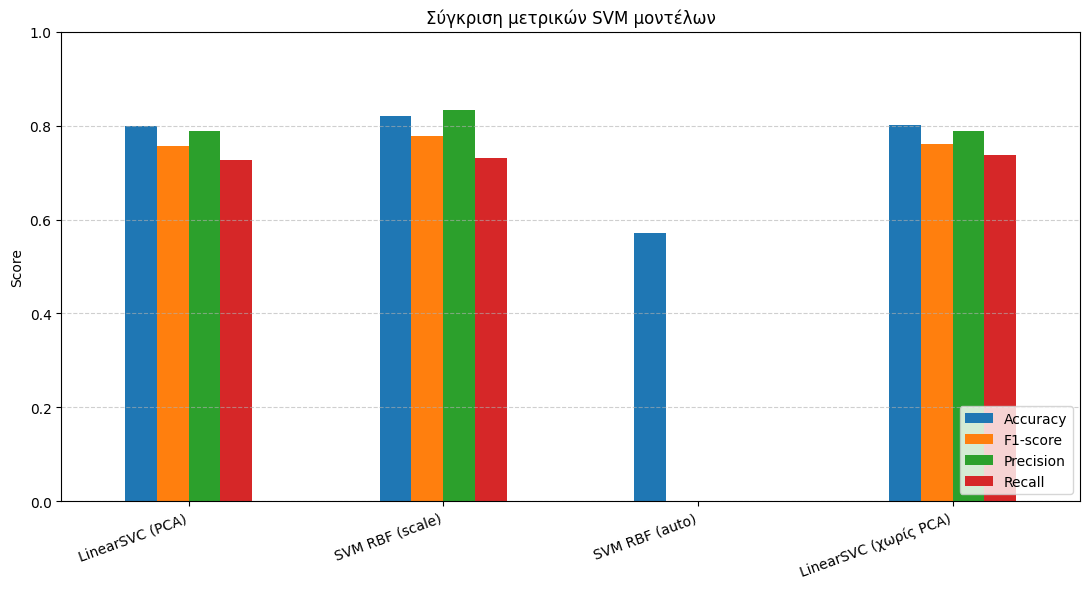

In [31]:
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "F1-score":  f1_score(y_true, y_pred, zero_division=0),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
    }

svm_rbf_auto = SVC(kernel='rbf', gamma='auto', random_state=0)
svm_rbf_auto.fit(X_train_pca, y_train_np)
y_pred_rbf_auto = svm_rbf_auto.predict(X_test_pca)

results_all = {
    "LinearSVC (PCA)":       evaluate_model(y_test_np, y_pred_linear),
    "SVM RBF (scale)":       evaluate_model(y_test_np, y_pred_rbf),
    "SVM RBF (auto)":        evaluate_model(y_test_np, y_pred_rbf_auto),
    "LinearSVC (χωρίς PCA)": evaluate_model(y_test_np, svm_model.predict(X_test_tfidf)),
}

results_all_df = pd.DataFrame(results_all).T[["Accuracy","F1-score","Precision","Recall"]]
print(results_all_df.round(3))

ax = results_all_df.plot(kind='bar', figsize=(11,6))
plt.title("Σύγκριση μετρικών SVM μοντέλων")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Με βάση τον πίνακα αποτελεσμάτων και το ραβδόγραμμα σύγκρισης, το μοντέλο SVM RBF (scale) εμφάνισε την καλύτερη συνολική απόδοση, με Accuracy=0.822, Precision=0.833 και F1-score=0.779, αποδεικνύοντας ότι ο προσαρμοστικός υπολογισμός της παραμέτρου γ (gamma='scale') εξασφαλίζει βέλτιστη ισορροπία μεταξύ Precision και Recall. Αντίθετα, το SVM RBF (auto) απέτυχε, παρουσιάζοντας μηδενικές τιμές στις μετρικές Precision, Recall και F1-score, γεγονός που δείχνει ότι η σταθερή τιμή γ = 1/n_features οδήγησε σε υποπροσαρμογή και σε μοντέλο που δεν μπόρεσε να εντοπίσει θετικά δείγματα. Τα μοντέλα LinearSVC, με και χωρίς PCA, παρουσίασαν συγκρίσιμα αποτελέσματα (Accuracy=0.80, F1=0.76) και υψηλή ικανότητα γενίκευσης, με το LinearSVC χωρίς PCA να επιτυγχάνει υψηλότερη τιμή Recall (0.737). Η εφαρμογή του PCA δεν βελτίωσε σημαντικά την ακρίβεια, αλλά βελτίωσε την ταχύτητα εκπαίδευσης.

Ερώτημα 9

In [33]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

gnb_model = GaussianNB()
gnb_model.fit(X_train_dense, y_train_np)

y_pred_train_gnb = gnb_model.predict(X_train_dense)
y_pred_test_gnb  = gnb_model.predict(X_test_dense)

metrics_gnb = {
    "Accuracy": [
        accuracy_score(y_train_np, y_pred_train_gnb),
        accuracy_score(y_test_np,  y_pred_test_gnb)
    ],
    "Precision": [
        precision_score(y_train_np, y_pred_train_gnb),
        precision_score(y_test_np,  y_pred_test_gnb)
    ],
    "Recall": [
        recall_score(y_train_np, y_pred_train_gnb),
        recall_score(y_test_np,  y_pred_test_gnb)
    ],
    "F1-score": [
        f1_score(y_train_np, y_pred_train_gnb),
        f1_score(y_test_np,  y_pred_test_gnb)
    ]
}

results_gnb_df = pd.DataFrame(metrics_gnb, index=["Train", "Test"])
print(results_gnb_df)

print("\nDetailed classification report (Test set):")
print(classification_report(y_test_np, y_pred_test_gnb))

       Accuracy  Precision    Recall  F1-score
Train  0.823529   0.977961  0.602921  0.745955
Test   0.763780   0.845070  0.550459  0.666667

Detailed classification report (Test set):
              precision    recall  f1-score   support

           0       0.73      0.92      0.82       435
           1       0.85      0.55      0.67       327

    accuracy                           0.76       762
   macro avg       0.79      0.74      0.74       762
weighted avg       0.78      0.76      0.75       762



Ο ταξινομητής Gaussian Naive Bayes παρουσίασε Accuracy=0.76 στο σύνολο δοκιμής, ελαφρώς χαμηλότερη από το SVM. Η Precision (0.85) είναι αρκετά υψηλή, γεγονός που σημαίνει ότι, όταν το μοντέλο προβλέπει την ύπαρξη φυσικής καταστροφής, είναι συνήθως σωστό. Ωστόσο, η Recall (0.55) είναι σχετικά χαμηλή, κάτι που δείχνει ότι εντοπίζει μόνο περίπου το 55% των πραγματικών περιστατικών, χάνοντας ένα σημαντικό ποσοστό. Η F1-score=0.67 αντικατοπτρίζει αυτή την ανισορροπία, προσφέροντας μια πιο ρεαλιστική εκτίμηση της συνολικής απόδοσης. Η απόδοση στο train set (Accuracy=0.82, F1=0.75) είναι υψηλότερη, αλλά όχι υπερβολικά, υποδηλώνοντας ότι το μοντέλο δεν υπερπροσαρμόζεται. Το Naive Bayes βασίζεται στην υπόθεση ανεξαρτησίας μεταξύ χαρακτηριστικών, η οποία δεν ισχύει πλήρως στα δεδομένα κειμένου, εξηγώντας τη χαμηλότερη Recall σε σχέση με το SVM.